<a href="https://colab.research.google.com/github/sravanisasu/10k-sample/blob/main/Binary_Classification_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Morlet Function**

In [14]:
# Morlet Function
def w_func(t):
  return torch.cos(1.75*t)* torch.exp(-(t**2))

**Required imports**

In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import weight_norm
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import minmax_scale  
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

**Pre-process the data**

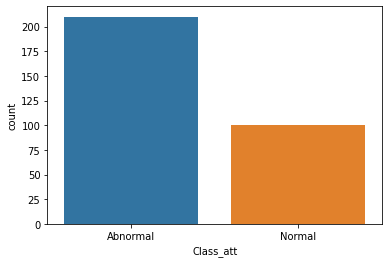

In [16]:
df = pd.read_csv("/content/Dataset_spine.csv")

# applying encoding for the output 0-normal and 1-abnormal
sns.countplot(x = 'Class_att', data=df)
df['Class_att'] = df['Class_att'].astype('category')
encode_map = {
    'Abnormal': 1,
    'Normal': 0
}
df['Class_att'].replace(encode_map, inplace=True)

X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=69)

# apply minmax scalar
X_train = minmax_scale(X_train)
X_test = minmax_scale(X_test)

**Initalise Hyper parameters**

In [17]:
nin = len(X.columns)
nhn = 10
non = 1

EPOCHS = 500
BATCH_SIZE = 64
LEARNING_RATE = 0.001

**Function for train dataset**

In [18]:
## train data
class trainData(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

**Function for test dataset**

In [19]:
## test data    
class testData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)

**Load Dataset**

In [20]:
#train
train_data = trainData(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

#test
test_data = testData(torch.FloatTensor(X_test))
test_loader = DataLoader(dataset=test_data, batch_size=1)

**Define Model**

In [21]:
class binaryClassification(nn.Module):
    def __init__(self):
        super(binaryClassification, self).__init__()
        self.fc1 = weight_norm(nn.Linear(nin, nhn, bias=False))
        self.fc2 = nn.Linear(nhn, non)
        self.a = nn.Parameter(torch.rand(nhn), requires_grad=True)
        self.b = nn.Parameter(torch.rand(nhn), requires_grad=True)
    def forward(self, x):
        t = (self.fc1(x)-self.b)/self.a
        vk = self.fc2(w_func(t))
        return vk

**Define accuracy function**

In [22]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#define model
model = binaryClassification()
model.to(device)

#define loss function
criterion = nn.BCEWithLogitsLoss()

#define optimiser
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

#train model
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

# evaluate or predit the results of model
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

print(roc_auc_score(y_test, y_pred_list))

Epoch 001: | Loss: 0.66498 | Acc: 66.250
Epoch 002: | Loss: 0.65643 | Acc: 67.750
Epoch 003: | Loss: 0.66480 | Acc: 62.750
Epoch 004: | Loss: 0.66919 | Acc: 61.250
Epoch 005: | Loss: 0.64693 | Acc: 68.000
Epoch 006: | Loss: 0.63751 | Acc: 70.750
Epoch 007: | Loss: 0.64822 | Acc: 66.750
Epoch 008: | Loss: 0.64275 | Acc: 67.750
Epoch 009: | Loss: 0.63938 | Acc: 67.750
Epoch 010: | Loss: 0.64277 | Acc: 67.000
Epoch 011: | Loss: 0.65748 | Acc: 63.000
Epoch 012: | Loss: 0.61645 | Acc: 71.750
Epoch 013: | Loss: 0.64407 | Acc: 65.250
Epoch 014: | Loss: 0.63784 | Acc: 66.750
Epoch 015: | Loss: 0.64356 | Acc: 64.000
Epoch 016: | Loss: 0.63101 | Acc: 66.750
Epoch 017: | Loss: 0.65116 | Acc: 63.000
Epoch 018: | Loss: 0.63311 | Acc: 66.750
Epoch 019: | Loss: 0.60328 | Acc: 71.500
Epoch 020: | Loss: 0.61653 | Acc: 69.000
Epoch 021: | Loss: 0.63025 | Acc: 66.750
Epoch 022: | Loss: 0.62834 | Acc: 65.250
Epoch 023: | Loss: 0.60953 | Acc: 70.500
Epoch 024: | Loss: 0.61394 | Acc: 67.750
Epoch 025: | Los